In [32]:
# Imports
from pathlib import Path
import os
import sys
import datetime
import math

# `DatasetLoader` is a custom helper class to retrieve data from hdf5 file
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb

In [27]:
# Settings
TABLE_NAME = "sensors_100hz"  # Table with raw sensor data
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
SEED = 712

FEATURE_COLS = [
    "acc_x",
    "acc_y",
    "acc_z",
]

REPORT_PATH = Path.cwd().parent / "reports" / "figures"  # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "siamesa_lstm_ocsvm"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

step_width = 50
window_size = 100
max_pairs_per_session = 60

In [18]:
# Load Dataset
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=TABLE_NAME,
    max_subjects=None,
    task_types=[],
    exclude_subjects=[],   
    exclude_cols=[],
    seed=SEED,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,all,7567.67,123988689,7,100,2392
1,index,0.09,2392,4,100,2392


Normalize all data before splitting into train and test sets...
Before Scaling:


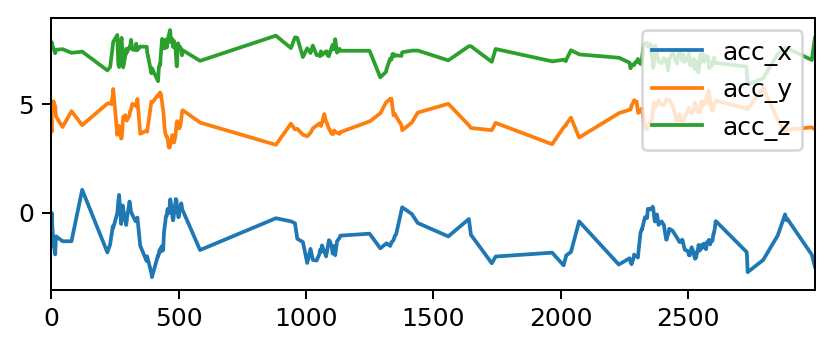

After Scaling:


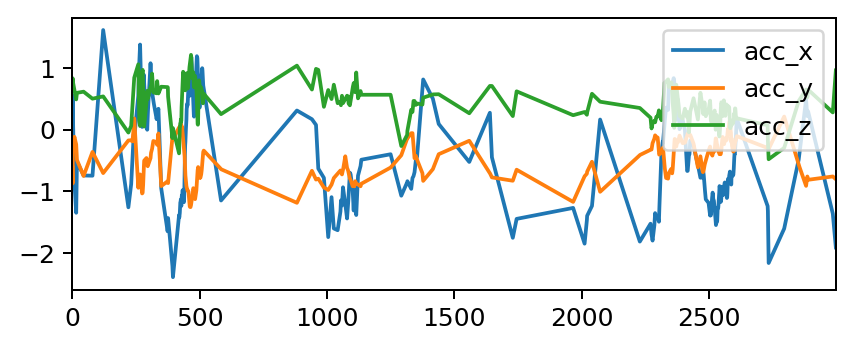

In [19]:
# Normalize Features

print("Normalize all data before splitting into train and test sets...")
hmog.all, scalers = utils_custom_scale(
    hmog.all,
    scale_cols=FEATURE_COLS,        
    feature_cols=FEATURE_COLS,
    scaler_name="robust",
    scope="subject",
    plot=True,
)

In [20]:
# Train Test Split

hmog.split_train_valid_train_test(
    n_valid_train=20,
    n_valid_test=5,
    n_test_train=20,
    n_test_test=5,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.09,2392,4,100,2392
1,valid_train,1494.19,24480879,7,20,479
2,valid_test,4164.21,68226338,7,55,1313
3,test_train,1558.75,25538547,7,20,480
4,test_test,350.52,5742925,7,5,120


In [21]:
# Check splits

#utils_split_report(hmog.valid_train)
#utils_split_report(hmog.valid_test)
#utils_split_report(hmog.test_train)
utils_split_report(hmog.test_test)

Unique subjects: 5
Unique sessions: 120

Head:


,acc_x,acc_y,acc_z,sys_time,subject,session,task_type
0,-0.262201,-0.038090,-0.462684,1402265978410,622852,622852_session_24,3
1,-0.273692,-0.037141,-0.467498,1402265978420,622852,622852_session_24,3
2,-0.285184,-0.036192,-0.472313,1402265978430,622852,622852_session_24,3
3,-0.296675,-0.035243,-0.477128,1402265978440,622852,622852_session_24,3
4,-0.308166,-0.034294,-0.481943,1402265978450,622852,622852_session_24,3




Sessions' Task Types per subject:


subject,326223,395129,553321,622852,856302
1,4,4,4,4,4
2,4,4,4,4,4
3,4,4,4,4,4
4,4,4,4,4,4
5,4,4,4,4,4
6,4,4,4,4,4


In [22]:
# Reshape & cache Set for Training Siamese Network:

df_siamese_train = utils_reshape_features(
    hmog.valid_train,
    feature_cols=FEATURE_COLS,
    window_size=window_size,
    step_width=step_width,
)

# Clean memory
del hmog.train
%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_siamese_train.head())

# Store iterim data
df_siamese_train.to_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

# Clean memory
%reset_selective -f df_siamese_train

Validation data after reshaping:


,X,subject,session,task_type
0,"[[0.724610678524777, -0.29974919556069796, 0.3...",180679,180679_session_1,3
1,"[[0.803400846508881, -0.2754501993084935, 0.29...",180679,180679_session_1,3
2,"[[0.3603175739943962, -0.21275098966322945, 0....",180679,180679_session_1,3
3,"[[-0.4862703573587255, -0.05992497772474931, 0...",180679,180679_session_1,3
4,"[[-0.9100325651872562, 0.20222913627208908, -0...",180679,180679_session_1,3


In [23]:
# Reshape & cache Set for Validating Siamese Network: (also used to optimize OCSVM)

df_siamese_valid = utils_reshape_features(
    hmog.valid_test,
    feature_cols=FEATURE_COLS,
    window_size=window_size,
    step_width=step_width,
)

del hmog.valid
%reset_selective -f hmog.valid

print("Testing data after reshaping:")
display(df_siamese_valid.head())

# Store iterim data
df_siamese_valid.to_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

# Clean memory
%reset_selective -f df_siamese_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[0.5518094610660693, 0.8685418918983016, -0.8...",100669,100669_session_1,1
1,"[[-0.13771758932865596, 1.0001144061546958, -1...",100669,100669_session_1,1
2,"[[-1.0881990471749163, 0.9336259435359944, -0....",100669,100669_session_1,1
3,"[[-0.4531115040869994, 1.0157542870090717, -0....",100669,100669_session_1,1
4,"[[0.5464489092120598, 0.9061910857184634, -0.7...",100669,100669_session_1,1


In [24]:
# Reshape & cache Set for Training/Validation OCSVM:

df_ocsvm_train_valid = utils_reshape_features(
    hmog.test_train,
    feature_cols=FEATURE_COLS,
    window_size=window_size,
    step_width=step_width,
)

del hmog.test_train
%reset_selective -f hmog.test_train

print("Testing data after reshaping:")
display(df_ocsvm_train_valid.head())

# Store iterim data
df_ocsvm_train_valid.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-0.32267448031635493, 0.13900393129339625, 0...",201848,201848_session_1,3
1,"[[-0.3334100174145684, 0.14099493116105513, 0....",201848,201848_session_1,3
2,"[[-0.3330398782044244, 0.14844757473625977, 0....",201848,201848_session_1,3
3,"[[-0.3422240010930933, 0.15051663599594356, 0....",201848,201848_session_1,3
4,"[[-0.33940669123086853, 0.15001775042172544, 0...",201848,201848_session_1,3


In [25]:
# Reshape & cache Set for Training/Testing OCSVM:

df_ocsvm_train_test = utils_reshape_features(
    hmog.test_test,
    feature_cols=FEATURE_COLS,
    window_size=window_size,
    step_width=step_width,
)

del hmog.test_test
%reset_selective -f hmog.test_test

print("Testing data after reshaping:")
display(df_ocsvm_train_test.head())

# Store iterim data
df_ocsvm_train_test.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_test
%reset_selective -f df_

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-0.50919458719606, -0.4305292593316341, 0.16...",326223,326223_session_1,6
1,"[[-0.009076187948776737, -0.43577071682932966,...",326223,326223_session_1,6
2,"[[-0.029423777066002563, -0.38958211649123875,...",326223,326223_session_1,6
3,"[[-0.6662612662984911, -0.7506180706479849, 1....",326223,326223_session_1,6
4,"[[-0.490974387587219, -0.12770299427861945, -0...",326223,326223_session_1,6


## Siamesa

In [26]:
# Load Dataset

df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

type(df_siamese_valid)
pd.unique(df_siamese_train["task_type"])
#df_siamese_valid["task_type"]

array([3, 1, 6, 2, 4, 5])

In [28]:
# Trainning Pairs

def build_pairs(df):
    # Limit samples per subject to sample of shortest session
    df = df.groupby("session", group_keys=False).apply(
        lambda x: x.sample(min(len(x), max_pairs_per_session), random_state=SEED)
    )
    df_pairs = None

    # Split samples subject wise 50:50
    # ---------------
    df_positives = None
    df_negatives = None

    for subject in df["subject"].unique():
        # Shuffle
        df_subj = df[df["subject"] == subject].sample(frac=1, random_state=SEED)

        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        half = len(df_subj) // 2

        df_positives = pd.concat([df_positives, df_subj.iloc[:half]])
        df_negatives = pd.concat([df_negatives, df_subj.iloc[half:]])

    # Positive Pairs
    # ---------------
    df_positive_left = None
    df_positive_right = None

    for subject in df_positives["subject"].unique():
        df_subj = df[df["subject"] == subject]
        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        # Split in half
        half = len(df_subj) // 2
        df_positive_left = pd.concat([df_positive_left, df_subj.iloc[:half]])
        df_positive_right = pd.concat([df_positive_right, df_subj.iloc[half:]])

    df_positive_left = df_positive_left.reset_index(drop=True)
    df_positive_right = df_positive_right.reset_index(drop=True)
    df_positive_left.columns = ["left_" + c for c in df_positive_left.columns]
    df_positive_right.columns = ["right_" + c for c in df_positive_right.columns]

    df_positives = pd.concat(
        [df_positive_left, df_positive_right],
        axis=1,
        sort=False,
        join_axes=[df_positive_left.index],
    )

    # Negative Pairs
    # ---------------
    # Make rows even
    if len(df_negatives) % 2 != 0:
        df_negatives = df_negatives.iloc[:-1]

    # Split in half
    half = len(df_negatives) // 2
    df_negative_left = df_negatives.iloc[half:].reset_index(drop=True)
    df_negative_right = df_negatives.iloc[:half].reset_index(drop=True)

    # Name columns
    df_negative_left.columns = ["left_" + c for c in df_negative_left.columns]
    df_negative_right.columns = ["right_" + c for c in df_negative_right.columns]

    # Combine
    df_negatives = pd.concat(
        [df_negative_left, df_negative_right],
        axis=1,
        sort=False,
        join_axes=[df_negative_left.index],
    )

    # Combine both Pairs
    # ---------------
    # Balance pairs
    min_len = min(len(df_positives), len(df_negatives))
    df_positives = df_positives.sample(n=min_len, random_state=SEED)
    df_negatives = df_negatives.sample(n=min_len, random_state=SEED)

    # Combine
    df_pairs = pd.concat([df_positives, df_negatives], sort=False)

    # Shuffle
    df_pairs = df_pairs.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Set Label
    df_pairs["label"] = np.where(
        df_pairs["left_subject"] == df_pairs["right_subject"], 1, 0
    )

    return df_pairs

In [36]:
seconds_per_subject = 60
frequency = 100
samples_per_subject_train = math.ceil(
            (seconds_per_subject * 100)
            / (100 / frequency)
            / window_size
        )

samples_per_subject_test = math.ceil(
            (seconds_per_subject * 100)
            / (100 / frequency)
            / window_size
        )
samples_per_subject_train

60

In [37]:
# Reduce observations/samples per
print("Sample per session before reduction:\n ")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

df_siamese_train = df_siamese_train.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), samples_per_subject_train), random_state=SEED)
)

df_siamese_valid = df_siamese_valid.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), samples_per_subject_test), random_state=SEED)
)

print("\n\nSample per session after reduction:\n")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

Sample per session before reduction:
 


256487_session_2    3286
278135_session_2    3126
256487_session_9    3012
Name: session, dtype: int64

733568_session_2    4174
527796_session_2    3874
856401_session_4    3666
Name: session, dtype: int64



Sample per session after reduction:



561993_session_11    60
220962_session_19    60
561993_session_4     60
Name: session, dtype: int64

539502_session_3     60
986737_session_24    60
698266_session_19    60
Name: session, dtype: int64

In [38]:
df_siamese_train_pairs = build_pairs(df_siamese_train)
df_siamese_valid_pairs = build_pairs(df_siamese_valid)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14370 entries, 0 to 14369
Data columns (total 9 columns):
left_X             14370 non-null object
left_subject       14370 non-null object
left_session       14370 non-null object
left_task_type     14370 non-null int64
right_X            14370 non-null object
right_subject      14370 non-null object
right_session      14370 non-null object
right_task_type    14370 non-null int64
label              14370 non-null int64
dtypes: int64(3), object(6)
memory usage: 1010.5+ KB


None



Head:


,left_X,left_subject,left_session,left_task_type,right_X,right_subject,right_session,right_task_type,label
0,"((-0.2982105895134419, 0.2763308583844435, 0.2...",489146,489146_session_13,5,"((-0.43563093794189744, 0.24205860266598386, 0...",489146,489146_session_24,5,1
1,"((-0.34090307605289566, -0.13929350772739596, ...",796581,796581_session_11,2,"((-1.2486689357077898, -0.9121021916628769, 1....",796581,796581_session_21,2,1
2,"((-0.07341348185361272, 0.31970786971335896, -...",918136,918136_session_12,5,"((-0.03821649589309727, 0.6857926682888348, -0...",405035,405035_session_7,3,0
3,"((-0.840120866424707, 0.041345891540257564, 0....",278135,278135_session_13,2,"((-0.1699609484062382, 0.24605690580738374, 0....",278135,278135_session_24,2,1
4,"((0.6704266431929137, 1.6885383504806708, -2.7...",923862,923862_session_24,2,"((-0.32541183080001845, -0.05552018376926782, ...",472761,472761_session_16,4,0




Any NaN values?


left_X             0
left_subject       0
left_session       0
left_task_type     0
right_X            0
right_subject      0
right_session      0
right_task_type    0
label              0
dtype: int64




Distribution of Samples per Subjects in training Data


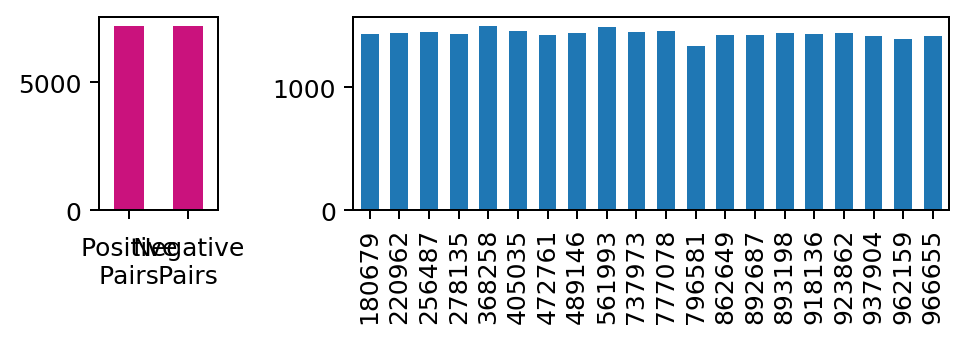

In [41]:
print("DataFrame Info:")
display(df_siamese_train_pairs.info())

print("\n\nHead:")
display(df_siamese_train_pairs.head(5))

print("\n\nAny NaN values?")
display(df_siamese_train_pairs.isnull().sum(axis = 0))

df_left_sub = df_siamese_train_pairs.groupby("left_subject")["left_subject"].count()
df_right_sub = df_siamese_train_pairs.groupby("right_subject")["right_subject"].count()
df_temp = pd.concat([df_left_sub, df_right_sub])

print("\n\n\nDistribution of Samples per Subjects in training Data")

fig, axes = plt.subplots(
    ncols=2, nrows=1, figsize=(5.473, 2), dpi=180, gridspec_kw={"width_ratios": [1, 5]}
)
df_siamese_train_pairs["label"].value_counts().rename(
    index={0: "Negative\nPairs", 1: "Positive\nPairs"}
).plot.bar(ax=axes[0], rot=0, color=MAGENTA)
axes[0].tick_params(axis="x", which="major", pad=7)
df_temp.groupby(df_temp.index).sum().plot.bar(ax=axes[1], width=0.6)
fig.tight_layout()

utils_save_plot(plt, REPORT_PATH / f"reproduced-siamese-lstm-ocsvm-pair-dist.pdf")

In [42]:
# Cache Pairs  
df_siamese_train_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

# Clean Memory
%reset_selective -f df_

In [3]:
# Training SiamesaLSTM with 60 users


In [4]:
# Transfer Learning

In [5]:
# Generate a Individual Model for each user (30 users)

In [6]:
# Running for Authentication Reability(ocsvm) 